In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')
from xraycam.camalysis import *

In [3]:
class Monitor:
    def __init__(self, *args, transpose = True, vmax = 150, rebin = 1, **kwargs):
        self.run = camcontrol.DataRun(*args, **kwargs)
        self.vmax = vmax
        self.rebin = rebin

    def frame(self):
        return self.run.get_frame()
    
    def update(self):
        self.run.show(vmax = self.vmax)
        self.run.plot_lineout(rebin = self.rebin)
        self.frame().plot_histogram(xmin = 0, xmax = self.vmax)
        
    def stop(self):
        self.run.stop()

#### code for runset arrays

In [3]:
from xraycam.camcontrol import _rebin_spectrum

In [4]:
def rebin_spc(arr2d,rebin=5):
    lineout = np.sum(arr2d,axis=0)/110
    return _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]

In [5]:
def _reorient_array(arr2d):
    """Take output from the get_array() method for dataruns from the new camera,
    and reorient them to match what our usual analysis code expects."""
    return np.transpose(arr2d[::,::-1])

NOTe to self Will: you changed the fitregionx on the below function definition because center_of_masses was throwing NaN

fitregionmode='man',fitregionx=[500,800]

In [6]:
def plot_with_energy_scale_arr2d(arr2d,known_energy,known_bin=None, photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange)[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,known_bin=known_bin,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()
    return lineout_energyscale

Note to self: need to fix the get_parabolic_lineout portion of this function.  See below.  Only works when cropping upper regions of the sensor because the fitregion needs to have the same x index range as the shape passed into parabolic_sort

In [7]:
def plot_with_energy_scale_arr2d_test(arr2d,known_energy,known_bin=None, photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange,fitregionmode='man',fitregiony=yrange)[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,known_bin=known_bin,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

don't need the function right beneath this anymore (had to make specific to zns to get it to work temporarily)

In [8]:
def plot_with_energy_scale_arr2d_zns(arr2d,known_energy,photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange,fitregionmode='man',fitregionx=[537-150,537+150])[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

In [7]:
def cropping_tool_arr2d(datarun,step,known_energy=2014,calcfwhm=True,**kwargs):
    [plot_with_energy_scale_arr2d(datarun,known_energy,label='['+','.join((str(i),str(i+step)))+']',yrange=[i,i+step],
                            show=False,calcfwhm=calcfwhm,**kwargs) for i in range(0,2000,step)]
    camcontrol.plt.show()

# PKalpha

In [5]:
gaprunset1 = camcontrol.RunSet(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            prefix = '9.21.gaprunset1',htime="5m",number_runs=24)

Loaded from cache.


In [6]:
gaprunset1.dataruns[1]

IndexError: list index out of range

In [23]:
labGaP =  np.transpose(np.genfromtxt('PKalpha_SampleCompare.8.19.csv', delimiter=',')[1:,(0,2)])
vx,vy = labGaP
labGaP = np.array([[*vx],[*vy/max(vy)]])

In [5]:
GaP2 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP2.9.16',htime="5m")

Loaded from cache.


In [9]:
GaP2.run.get_frame().get_lineout()

[array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          1.09100000e+03,   1.09200000e+03,   1.09300000e+03]),
 array([  9.99090909,  46.81818182,  41.75454545, ...,  91.97272727,
         99.61818182,  99.02727273])]

In [20]:
GaP2arr=_reorient_array(GaP2.run.get_array())

In [9]:
gaparr = _reorient_array(np.sum([x.get_array() for x in gaprunset1.dataruns],axis=0))

In [15]:
#plt.plot(*labGaP,label='Moxtek')
plot_with_energy_scale(GaP2.run,2014.06,known_bin=None,label='Varian',rebin=3,
                           yrange=[900,1200],show=False,calcfwhm=False,peaknormalize=True,parabolic=False)
#plot_with_energy_scale_arr2d(gaparr,2014.06,label="ALS - parab",yrange=[0,-1],parabolic=True,rebin=5,show=False,calcfwhm=False,peaknormalize=True)
#plot_with_energy_scale_arr2d(gaparr,2014.06,label="ALS - col",parabolic=False,rebin=5,show=False,calcfwhm=False,peaknormalize=True)
plt.show()

In [50]:
from matplotlib.pyplot import matshow

<IPython.core.display.Javascript object>


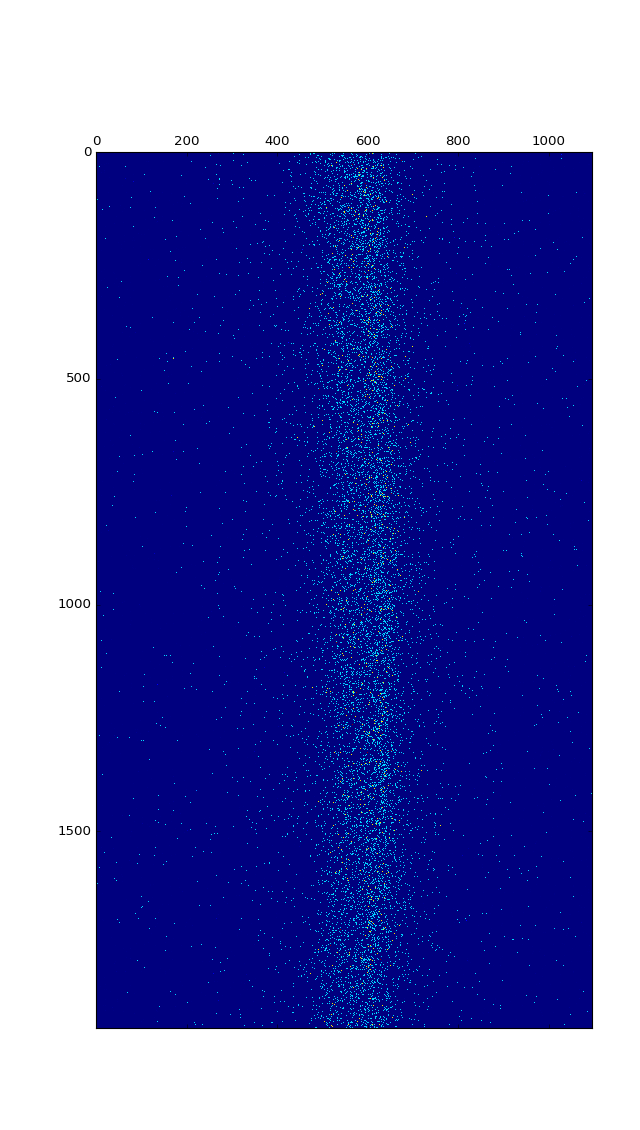

<IPython.core.display.Javascript object>


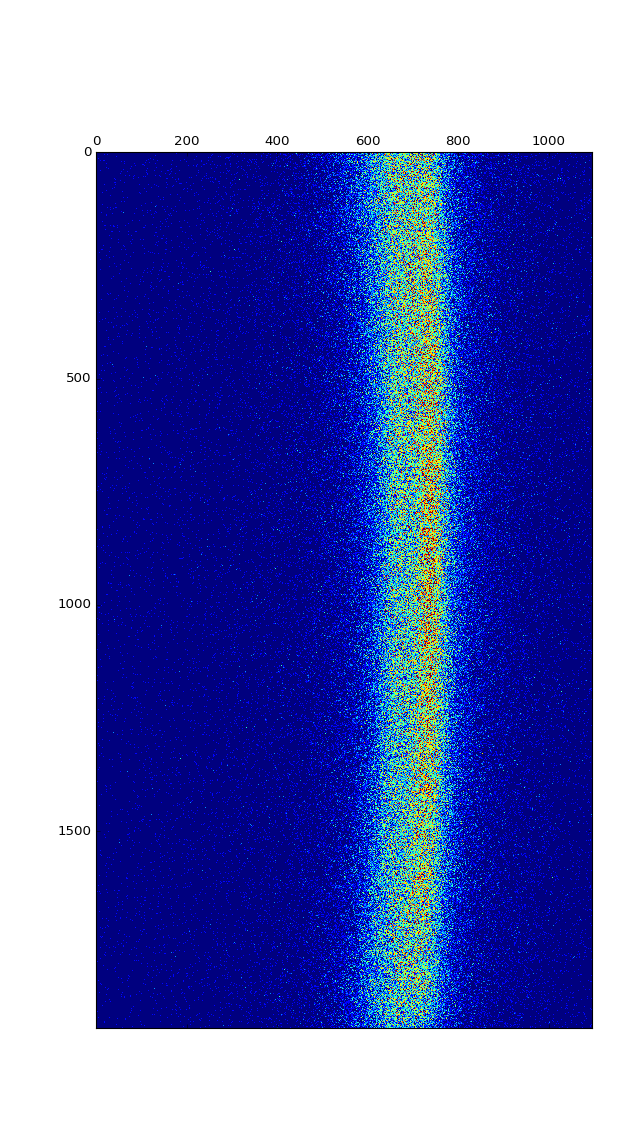

In [109]:
matplotlib.pyplot.figure(num=2,figsize=(8,8*1936/1096))
matplotlib.pyplot.figure(num=3,figsize=(8,8*1936/1096))
matplotlib.pyplot.matshow(gaparr,fignum=2,vmax=max(gaparr.ravel())*1/2)
matplotlib.pyplot.matshow(GaP2arr,fignum=3,vmax=max(GaP2arr.ravel())*1/2)
matplotlib.pyplot.show()

In [132]:
cropping_tool_arr2d(gaparr,400,calfwhm=False,rebin=5,peaknormalize=True)

In [131]:
cropping_tool(GaP2.run,400,rebin=3)

#### compare count rates

In [18]:
np.mean([x.counts_per_second() for x in gaprunset1.dataruns])

7.9803082475809992

In [62]:
GaP2.run.counts_per_second()

4390.3506775873566

## SKalpha Import ALS data

In [26]:
zns4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.zns4')
zns4.run.theta=115

Loaded from cache.


In [27]:
znsrunset0 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.znsrunset0',htime="5m",number_runs=24)

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.


In [30]:
znsarr0=_reorient_array(np.sum([x.get_array() for x in znsrunset0.dataruns],axis=0))

In [31]:
znsarrtotal=_reorient_array(zns4.run.get_array())+znsarr0

In [67]:
zns_lineout = plot_with_energy_scale_arr2d(znsarrtotal,2307.7,label="zns",rebin=2,yrange=[0,1300],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)

## Import Moridata

In [32]:
moridata =  np.genfromtxt('moriData_ZnSKalpha.csv', delimiter=',')

## Import Labdata (taken with Varian)

In [33]:
labdata = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'zns0.contd.9.15')

Loaded from cache.


# Analysis code

gaussian broadening code

In [34]:
def bwev(datarun,i):
    return datarun[i+1,0]-datarun[i,0]

In [35]:
def gauss_broaden(datarun,fwhm):
    pointspacing = bwev(datarun,10)
    sigma=fwhm/(2*np.sqrt(2*np.log(2)))
    f = int(sigma/pointspacing)
    d = np.transpose(datarun)
    dx, dy = d
    return np.array([gfilt(dx,f),gfilt(dy,f)/max(gfilt(dy,f))])

delta function test of gauss_broaden algorithm

In [36]:
def deltafunc(w):
    arr = np.append(np.append(np.zeros(int(w/2)),1),np.zeros(int(w/2-1)))
    energy_arr = np.arange(2012,2013,1/w)
    return np.array([[*energy_arr],[*arr]])

In [18]:
plt.plot(*gauss_broaden(np.transpose(deltafunc(1000)),0.25),label='test')
plt.show()

#### compare count rates

In [54]:
zns4.run.counts_per_second()

7.2984205828871831

In [56]:
np.mean([x.counts_per_second() for x in znsrunset0.dataruns])

7.2796437638699265

#### now compare ALS data to broadened MoriData

In [77]:
#plt.plot(*np.transpose(moridata),label='Mori')
#plt.plot(*gauss_broaden(moridata,0.5),label='Mori - '+str(0.5)+' eV')
plt.plot(*zns_lineout,label='ALS')
plot_with_energy_scale(labdata.run,2307.7,label="Varian",rebin=2,yrange=[500,1000],calcfwhm=False,show=False,peaknormalize=True)
plt.show()

## playing with different analysis below
## ____________ ________ ______ _____ 

compare mori with Varian data

In [23]:
plt.plot(*gauss_broaden(moridata,0.5),label='Mori - '+str(0.5)+' eV')
plot_with_energy_scale(labdata.run,2307.7,label="Varian",rebin=2,yrange=[500,1000],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plt.show()

In [53]:
np.shape(labdata.run.get_array())

(1096, 1936)

try bg subtracting ALS data

In [76]:
plt.plot(*np.array([[*zns_lineout[0]],[*zns_lineout[1]-.02]]),label='zns - bg subtract')
plt.plot(*gauss_broaden(moridata,0.4),label='Mori - '+str(0.5)+' eV')
plt.show()

In [120]:
x,y = np.indices((5,5),dtype='int')

In [121]:
x

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [122]:
y

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [128]:
z=-0.5*x**2+2*x+y

In [129]:
z

array([[ 0. ,  1. ,  2. ,  3. ,  4. ],
       [ 1.5,  2.5,  3.5,  4.5,  5.5],
       [ 2. ,  3. ,  4. ,  5. ,  6. ],
       [ 1.5,  2.5,  3.5,  4.5,  5.5],
       [ 0. ,  1. ,  2. ,  3. ,  4. ]])

In [130]:
np.ravel(z)

array([ 0. ,  1. ,  2. ,  3. ,  4. ,  1.5,  2.5,  3.5,  4.5,  5.5,  2. ,
        3. ,  4. ,  5. ,  6. ,  1.5,  2.5,  3.5,  4.5,  5.5,  0. ,  1. ,
        2. ,  3. ,  4. ])

In [131]:
np.argsort(z.ravel())

array([ 0, 20,  1, 21,  5, 15,  2, 22, 10,  6, 16,  3, 11, 23,  7, 17, 12,
        4, 24, 18,  8, 13, 19,  9, 14])

In [133]:
np.unravel_index(np.argsort(z.ravel()),z.shape)

(array([0, 4, 0, 4, 1, 3, 0, 4, 2, 1, 3, 0, 2, 4, 1, 3, 2, 0, 4, 3, 1, 2, 3,
        1, 2]),
 array([0, 0, 1, 1, 0, 0, 2, 2, 0, 1, 1, 3, 1, 3, 2, 2, 2, 4, 4, 3, 3, 3, 4,
        4, 4]))

In [78]:
np.indices?

In [85]:
np.unravel_index?

In [86]:
np.ravel?

In [88]:
np.ravel([[2,2],[3,3],[[4,4]]])

array([[2, 2], [3, 3], [[4, 4]]], dtype=object)

In [90]:
[2,3,4].t

AttributeError: 'list' object has no attribute 't'